#### This notebook demonstrates the use of an odds-equalizing post-processing algorithm for bias mitigiation.


In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

pip install 'aif360[AdversarialDebiasing]'


### Fairness metrics for original dataset

In [2]:
## import dataset
dataset_used = "compas" # "adult", "german", "compas"
protected_attribute_used = 2 # 1, 2

if dataset_used == "adult":
    dataset_orig = AdultDataset()
#     dataset_orig = load_preproc_data_adult()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
    
elif dataset_used == "german":
    dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    dataset_orig = load_preproc_data_compas()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]    

# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "fnr" # "fnr", "fpr", "weighted"
#random seed for calibrated equal odds prediction
randseed = 12345679 

#### Divide dataset into train, validation, and test partitions (70-30)

In [3]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.6], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Training data characteristics

In [4]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Dataset shape

(3166, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


#### Metric for the original datasets (without any classifiers)

In [5]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_valid = BinaryLabelDatasetMetric(dataset_orig_valid, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original validation dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_valid.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.117565


#### Original validation dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.207803


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.100885


### Train classifier (logistic regression on original training data)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

# Placeholder for predicted and transformed datasets
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)

dataset_new_valid_pred = dataset_orig_valid.copy(deepcopy=True)
dataset_new_test_pred = dataset_orig_test.copy(deepcopy=True)

# Logistic regression classifier and predictions for training data
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
lmod = LogisticRegression()
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]
y_train_pred_prob = lmod.predict_proba(X_train)[:,fav_idx]

# Prediction probs for validation and testing data
X_valid = scale_orig.transform(dataset_orig_valid.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:,fav_idx]

X_test = scale_orig.transform(dataset_orig_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:,fav_idx]

class_thresh = 0.5
dataset_orig_train_pred.scores = y_train_pred_prob.reshape(-1,1)
dataset_orig_valid_pred.scores = y_valid_pred_prob.reshape(-1,1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1,1)

y_train_pred = np.zeros_like(dataset_orig_train_pred.labels)
y_train_pred[y_train_pred_prob >= class_thresh] = dataset_orig_train_pred.favorable_label
y_train_pred[~(y_train_pred_prob >= class_thresh)] = dataset_orig_train_pred.unfavorable_label
dataset_orig_train_pred.labels = y_train_pred

y_valid_pred = np.zeros_like(dataset_orig_valid_pred.labels)
y_valid_pred[y_valid_pred_prob >= class_thresh] = dataset_orig_valid_pred.favorable_label
y_valid_pred[~(y_valid_pred_prob >= class_thresh)] = dataset_orig_valid_pred.unfavorable_label
dataset_orig_valid_pred.labels = y_valid_pred
    
y_test_pred = np.zeros_like(dataset_orig_test_pred.labels)
y_test_pred[y_test_pred_prob >= class_thresh] = dataset_orig_test_pred.favorable_label
y_test_pred[~(y_test_pred_prob >= class_thresh)] = dataset_orig_test_pred.unfavorable_label
dataset_orig_test_pred.labels = y_test_pred

#### Results before post-processing

In [7]:
cm_pred_train = ClassificationMetric(dataset_orig_train, dataset_orig_train_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted training dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_train.difference(cm_pred_train.generalized_false_negative_rate))

cm_pred_valid = ClassificationMetric(dataset_orig_valid, dataset_orig_valid_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted validation dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate))

cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Original-Predicted testing dataset"))
print("Difference in GFPR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
print("Difference in GFNR between unprivileged and privileged groups")
print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

#### Original-Predicted training dataset

Difference in GFPR between unprivileged and privileged groups
-0.11399585418063496
Difference in GFNR between unprivileged and privileged groups
0.0939141176455171


#### Original-Predicted validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.059248581971303116
Difference in GFNR between unprivileged and privileged groups
0.10279416801722246


#### Original-Predicted testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.10632990908460332
Difference in GFNR between unprivileged and privileged groups
0.08350622086455517


### Perform odds equalizing post processing on scores

100%|██████████| 100/100 [00:05<00:00, 18.83it/s]


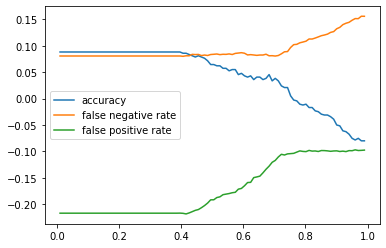

In [8]:
# Odds equalizing post-processing algorithm


##########



###NEW STUFF STARTS HERE


##########



from variable_cep import CalibratedEqOddsPostprocessing
from tqdm import tqdm

negs = []
accs = []
fps = []
fns = []

for neg in tqdm(np.linspace(0.01,0.99,100)):
    negative_val = neg
    positive_val = 1.0 - negative_val

    NP = (negative_val,positive_val)

    # Learn parameters to equalize odds and apply to create a new dataset
    cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                        unprivileged_groups = unprivileged_groups,
                                        cost_constraint='specified',
                                        seed=randseed,NP_rate=NP)
    cpp = cpp.fit(dataset_orig_valid, dataset_orig_valid_pred)

    dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
    dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

    cm_transf_valid = ClassificationMetric(dataset_orig_valid, dataset_transf_valid_pred,
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

    """
    display(Markdown("#### Original-Transformed validation dataset"))
    print("Difference in GFPR between unprivileged and privileged groups")
    print(cm_transf_valid.difference(cm_transf_valid.generalized_false_positive_rate))
    print("Difference in GFNR between unprivileged and privileged groups")
    print(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate))
    """
    cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_transf_test_pred,
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

    """
    display(Markdown("#### Original-Transformed testing dataset"))
    print("Difference in GFPR between unprivileged and privileged groups "+str(NP))
    print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
    print("Difference in GFNR between unprivileged and privileged groups "+str(NP))
    print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))
    print("Test Acc diff:")
    print(cm_transf_test.difference(cm_transf_test.accuracy))
    """
    negs.append(neg)
    fns.append(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))
    fps.append(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
    accs.append(float(cm_transf_test.difference(cm_transf_test.accuracy)))

plt.plot(negs,accs,label='accuracy')
plt.plot(negs,fns,label='false negative rate')
plt.plot(negs,fps,label='false positive rate')
plt.legend()

    




### Transform validation and test data using the post processing algorithm

#### Results after post-processing

#### Original-Transformed validation dataset

Difference in GFPR between unprivileged and privileged groups
-0.19439218630396393
Difference in GFNR between unprivileged and privileged groups
0.06404908706076196


#### Original-Transformed testing dataset

Difference in GFPR between unprivileged and privileged groups
-0.16359036124340914
Difference in GFNR between unprivileged and privileged groups
0.04685973646115715


In [9]:
# Testing: Check if the rates for validation data has gone down
assert np.abs(cm_transf_valid.difference(cm_transf_valid.generalized_false_negative_rate)) < np.abs(cm_pred_valid.difference(cm_pred_valid.generalized_false_negative_rate)) 

AssertionError: 

In [10]:
# Thresholds
all_thresh = np.linspace(0.01, 0.99, 25)
display(Markdown("#### Classification thresholds used for validation and parameter selection"))

bef_avg_odds_diff_test = []
bef_avg_odds_diff_valid = []
aft_avg_odds_diff_test = []
aft_avg_odds_diff_valid = []
bef_bal_acc_valid = []
bef_bal_acc_test = []
aft_bal_acc_valid = []
aft_bal_acc_test = []
for thresh in tqdm(all_thresh):
    
    dataset_orig_valid_pred_thresh = dataset_orig_valid_pred.copy(deepcopy=True)
    dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
    dataset_transf_valid_pred_thresh = dataset_transf_valid_pred.copy(deepcopy=True)
    dataset_transf_test_pred_thresh = dataset_transf_test_pred.copy(deepcopy=True)
    
    # Labels for the datasets from scores
    y_temp = np.zeros_like(dataset_orig_valid_pred_thresh.labels)
    y_temp[dataset_orig_valid_pred_thresh.scores >= thresh] = dataset_orig_valid_pred_thresh.favorable_label
    y_temp[~(dataset_orig_valid_pred_thresh.scores >= thresh)] = dataset_orig_valid_pred_thresh.unfavorable_label
    dataset_orig_valid_pred_thresh.labels = y_temp

    y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
    y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
    y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
    dataset_orig_test_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_valid_pred_thresh.labels)
    y_temp[dataset_transf_valid_pred_thresh.scores >= thresh] = dataset_transf_valid_pred_thresh.favorable_label
    y_temp[~(dataset_transf_valid_pred_thresh.scores >= thresh)] = dataset_transf_valid_pred_thresh.unfavorable_label
    dataset_transf_valid_pred_thresh.labels = y_temp
    
    y_temp = np.zeros_like(dataset_transf_test_pred_thresh.labels)
    y_temp[dataset_transf_test_pred_thresh.scores >= thresh] = dataset_transf_test_pred_thresh.favorable_label
    y_temp[~(dataset_transf_test_pred_thresh.scores >= thresh)] = dataset_transf_test_pred_thresh.unfavorable_label
    dataset_transf_test_pred_thresh.labels = y_temp
    
    # Metrics for original validation data
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                                 dataset_orig_valid_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_valid.append(classified_metric_orig_valid.equal_opportunity_difference())

    bef_bal_acc_valid.append(0.5*(classified_metric_orig_valid.true_positive_rate()+
                              classified_metric_orig_valid.true_negative_rate()))

    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_orig_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
    bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
                              classified_metric_orig_test.true_negative_rate()))

    # Metrics for transf validing data
    classified_metric_transf_valid = ClassificationMetric(
                                     dataset_orig_valid, 
                                     dataset_transf_valid_pred_thresh,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)
    aft_avg_odds_diff_valid.append(classified_metric_transf_valid.equal_opportunity_difference())
    aft_bal_acc_valid.append(0.5*(classified_metric_transf_valid.true_positive_rate()+
                              classified_metric_transf_valid.true_negative_rate()))

    # Metrics for transf validation data
    classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
                                                 dataset_transf_test_pred_thresh,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
    aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
                                  classified_metric_transf_test.true_negative_rate()))


#### Classification thresholds used for validation and parameter selection

100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


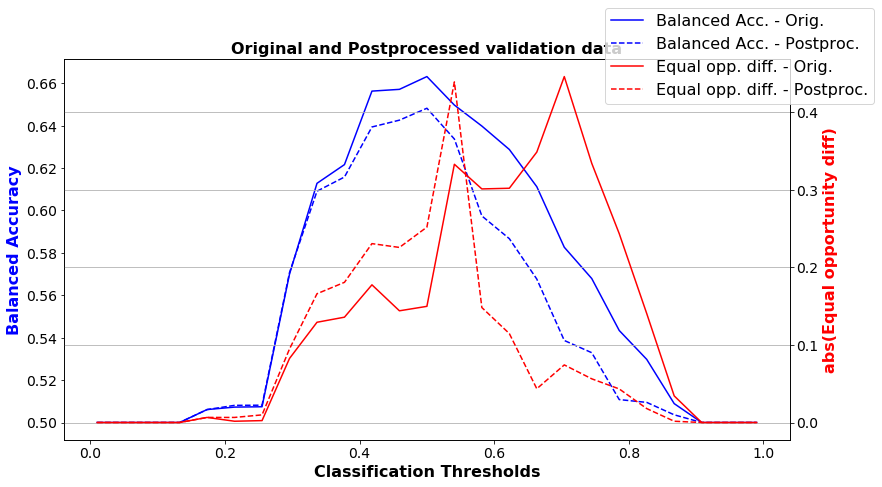

In [11]:
bef_bal_acc_valid = np.array(bef_bal_acc_valid)
bef_avg_odds_diff_valid = np.array(bef_avg_odds_diff_valid)

aft_bal_acc_valid = np.array(aft_bal_acc_valid)
aft_avg_odds_diff_valid = np.array(aft_avg_odds_diff_valid)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_valid, color='b')
ax1.plot(all_thresh, aft_bal_acc_valid, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed validation data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_valid), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_valid), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
             "Equal opp. diff. - Orig.","Equal opp. diff. - Postproc.",], 
           fontsize=16)

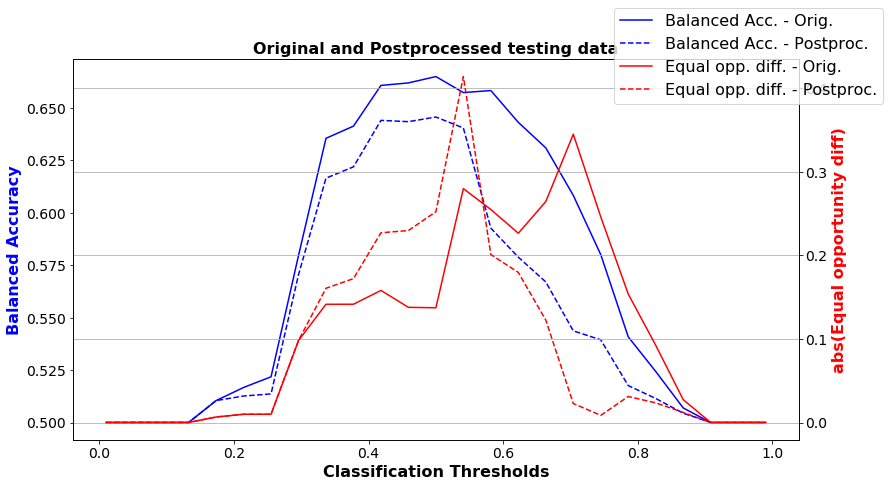

In [12]:
bef_bal_acc_test = np.array(bef_bal_acc_test)
bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

aft_bal_acc_test = np.array(aft_bal_acc_test)
aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

fig, ax1 = plt.subplots(figsize=(13,7))
ax1.plot(all_thresh, bef_bal_acc_test, color='b')
ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)
fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
            "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
           fontsize=16)